In [1]:
import random
random.seed(42)

import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
import numpy as np
import pandas as pd
import shap
import tqdm

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import sklearn.metrics as skmetrics
from sklearn.calibration import CalibrationDisplay
from sklearn.utils import resample

from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from process_fe import create_feature_engineering_datasets
from data import data_to_array_dict, get_data_date_split, get_data_date_id_split, get_feature_colnames
from utils import stratification
from plotting import paper_theme, ReliabilityDisplay, ShapDisplay, risk_feature_plot
import metrics
from shap_calculator import calc_shap_df

from tqdm_style import tqdm_style
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim

/Users/kx/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Fixing the training set and predicting on the last year

In [21]:
N_DAYS = 3
THRESHOLDS = [0.3, 0.8]
DATES_SPLIT = {
    "date_train_start": "2021-06-28",
    "date_train_end": "2023-01-01",
    "date_test_end": "2024-01-01",
}

In [22]:
col_nice_names = {
    'awake_freq': 'Night time Awake Frequency', 
    'bathroom_daytime_freq': 'Daytime Bathroom Frequency', 
    'bathroom_daytime_freq_ma': 'Daytime Bathroom Frequency MA', 
    'bathroom_daytime_freq_ma_delta': 'Daytime Bathroom Frequency MA Delta', 
    'bathroom_freq': 'Bathroom Frequency',
    'bathroom_nighttime_freq': 'Night time Bathroom Frequency', 
    'bathroom_nighttime_freq_ma': 'Night time Bathroom Frequency MA', 
    'bathroom_nighttime_freq_ma_delta': 'Night time Bathroom Frequency MA Delta', 
    'bathroom_relative_transition_time_delta_mean': 'Mean Relative Bathroom Transition Time Delta',
    'bathroom_relative_transition_time_delta_std': 'STD Relative Bathroom Transition Time Delta',
    'bedroom_freq': 'Bedroom Frequency',
    'daily_entropy': 'Daily Entropy', 
    'hallway_freq': 'Hallway Frequency', 
    'heart_rate_mean': 'Mean Night Time Heart Rate',
    'heart_rate_std': 'STD Night Time Heart Rate', 
    'kitchen_freq': 'Kitchen Frequency', 
    'lounge_freq': 'Lounge Frequency', 
    'previous_uti': 'Number of Previous UTIs',
    'respiratory_rate_mean': 'Mean Night Time Respiratory Rate', 
    'respiratory_rate_std': 'STD Night Time Respiratory Rate',
}

## A MLP

In [23]:
fe_data = create_feature_engineering_datasets(reload=False)

In [24]:
print(fe_data.columns)

Index(['patient_id', 'date', 'bathroom_freq', 'bedroom_freq', 'hallway_freq',
       'kitchen_freq', 'lounge_freq', 'awake_freq', 'heart_rate_mean',
       'heart_rate_std', 'respiratory_rate_mean', 'respiratory_rate_std',
       'bathroom_nighttime_freq', 'bathroom_nighttime_freq_ma',
       'bathroom_nighttime_freq_ma_delta', 'bathroom_daytime_freq',
       'bathroom_daytime_freq_ma', 'bathroom_daytime_freq_ma_delta',
       'daily_entropy', 'bathroom_relative_transition_time_delta_mean',
       'bathroom_relative_transition_time_delta_std', 'previous_uti'],
      dtype='object')


In [25]:

data_train, data_test, _ = get_data_date_split(
    fe_data, dates_split=DATES_SPLIT, n_days=N_DAYS, impute=True
)


X_train, y_train, ids_train, sample_weight = (
    data_train['X'], data_train['y'], data_train["id"], data_train['sample_weight']
)

X_test, y_test, ids_test, dates_test = (
    data_test['X'], data_test['y'], data_test["id"], data_test['date']
)

/Users/kx/MSc/uti_risk_to_share/process_fe.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels[


In [26]:
# Convert IDs to sets
set_ids_train = set(ids_train)
set_ids_test = set(ids_test)

# Check for intersection
common_ids = set_ids_train.intersection(set_ids_test)

# Check if there are any common elements
if common_ids:
    print(f"There are {len(common_ids)} common IDs between train and test datasets.")
else:
    print("IDs in train and test datasets are unique to each other.")

There are 41 common IDs between train and test datasets.


In [27]:
# List of IDs to remove
ids_to_remove = ['AboZyUBeiQW3nVCcbXGpay', 'NZjrVTZQR1w9LPJMt26MbG', 'XVb8nztyc2LYPCAewZq11S', 'XdbAAiDw1vd3Bjbo9EVo1B']

# Create a boolean index where False indicates IDs that need to be removed
indices_to_keep = ~np.isin(data_test['id'], ids_to_remove)

# Use this index to filter all related arrays in data_test
data_test['X'] = data_test['X'][indices_to_keep]
data_test['y'] = data_test['y'][indices_to_keep]
data_test['id'] = data_test['id'][indices_to_keep]
data_test['date'] = data_test['date'][indices_to_keep] if 'date' in data_test else None

X_test, y_test, ids_test, dates_test = (
    data_test['X'], data_test['y'], data_test["id"], data_test['date']
)

In [28]:
print("id_train:", ids_train.shape)
print("id_test:", ids_test.shape)

id_train: (1839,)
id_test: (1145,)


In [29]:
# Convert the NumPy array to a pandas Series
ids_train_series = pd.Series(ids_train)

# Now you can use the nunique() method
unique_count = ids_train_series.nunique()

print("Number of unique elements in ids_train:", unique_count)

Number of unique elements in ids_train: 69


In [30]:
ids_train_series = pd.Series(ids_test)

# Now you can use the nunique() method
unique_count = ids_train_series.nunique()

print("Number of unique elements in ids_test:", unique_count)

Number of unique elements in ids_test: 51


In [31]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (1839, 3, 20)
Shape of y_train: (1839,)
Shape of X_test: (1145, 3, 20)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define flatten function
def flatten(x):
    return x.reshape(x.shape[0], -1)

# Apply flattening
X_train_flattened = flatten(X_train)
X_test_flattened = flatten(X_test)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
sample_weight_torch = torch.tensor(sample_weight, dtype=torch.float32)

In [33]:
gender_map['gender_encoded'] = gender_map['Gender PwD'].map({'Male': 0, 'Female': 1})


patient_gender_dict = dict(zip(gender_map['patient_id'], gender_map['gender_encoded']))

gender_train = [patient_gender_dict.get(patient_id, 0) for patient_id in ids_train] 

gender_test = [patient_gender_dict.get(patient_id, 0) for patient_id in ids_test] 

gender_train = np.array(gender_train).astype(int)
gender_test = np.array(gender_test).astype(int)

In [34]:
print("Gender distribution in training data:", np.unique(gender_train, return_counts=True))
print("Gender distribution in testing data:", np.unique(gender_test, return_counts=True))

Gender distribution in training data: (array([0, 1]), array([1183,  656]))
Gender distribution in testing data: (array([0, 1]), array([695, 450]))


In [35]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels, gender, patient_id, sample_weight=None):
        """
        Constructor for the dataset.
        :param features: The input features (numpy array).
        :param labels: The labels corresponding to the features (numpy array).
        :param gender: The gender information (numpy array).
        :param sample_weight: Optional sample weights (numpy array).
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

        self.gender = torch.tensor(gender, dtype=torch.long)  # Assuming gender is categorical
        
        self.patient_id = patient_id
        
        if sample_weight is not None:
            self.sample_weight = torch.tensor(sample_weight, dtype=torch.float32)
        else:
            self.sample_weight = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.sample_weight is not None:
            return self.features[index], self.labels[index],self.loss_labels[index], self.gender[index], self.sample_weight[index], self.patient_id[index]
        return self.features[index], self.labels[index], self.loss_labels[index], self.patient_id[index]

# Instantiate datasets
train_dataset = CustomDataset(X_train_scaled, y_train, gender_train, ids_train, sample_weight)
test_dataset = CustomDataset(X_test_scaled, y_test, gender_test, ids_test, sample_weight)

## Feature clustering

For n_clusters = 2, the silhouette score is 0.2151843011379242
For n_clusters = 3, the silhouette score is 0.14277058839797974
For n_clusters = 4, the silhouette score is 0.15234123170375824
For n_clusters = 5, the silhouette score is 0.1010468527674675
For n_clusters = 6, the silhouette score is 0.1060120016336441
For n_clusters = 7, the silhouette score is 0.11418475210666656
For n_clusters = 8, the silhouette score is 0.11274631321430206
For n_clusters = 9, the silhouette score is 0.09076707810163498
For n_clusters = 10, the silhouette score is 0.10507524758577347
   Number of Clusters  Silhouette Score
0                   2          0.215184
1                   4          0.152341
2                   3          0.142771
3                   7          0.114185
4                   8          0.112746
5                   6          0.106012
6                  10          0.105075
7                   5          0.101047
8                   9          0.090767


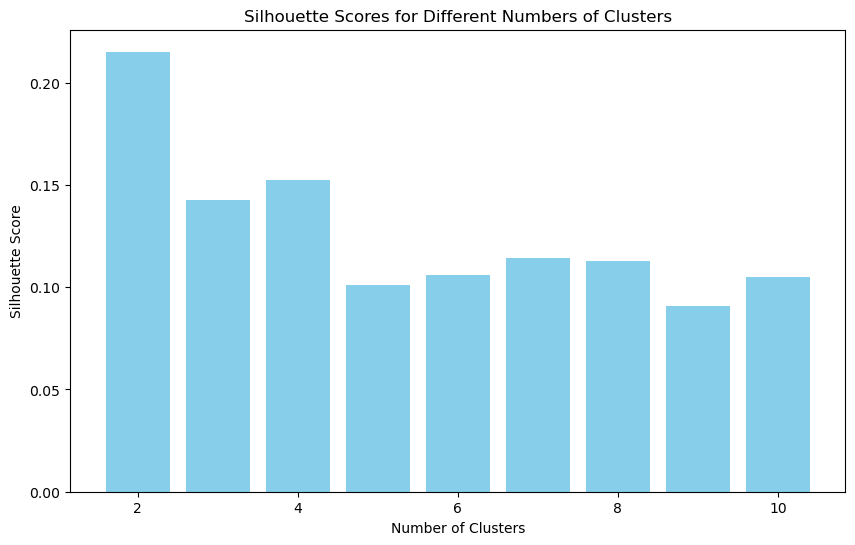

In [37]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range for the number of clusters
cluster_range = range(2, 11)

# Dictionary to store silhouette scores
silhouette_scores = {}

# Perform KMeans clustering for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")

# Convert silhouette scores to a DataFrame for easier visualization
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['Number of Clusters', 'Silhouette Score'])
silhouette_df = silhouette_df.sort_values(by='Silhouette Score', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(silhouette_df)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_df['Number of Clusters'], silhouette_df['Silhouette Score'], color='skyblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## two clusters

In [39]:
# Fit the KMeans model with the optimal number of clusters on the train data
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_train = kmeans.fit_predict(X_train_scaled)

# Predict clusters for the test data using the same KMeans model
cluster_test = kmeans.predict(X_test_scaled)

# Print the number of points in each cluster
print(f"Number of points in cluster 0 (train): {np.sum(cluster_train == 0)}")
print(f"Number of points in cluster 1 (train): {np.sum(cluster_train == 1)}")
print(f"Number of points in cluster 0 (test): {np.sum(cluster_test == 0)}")
print(f"Number of points in cluster 1 (test): {np.sum(cluster_test == 1)}")

Number of points in cluster 0 (train): 361
Number of points in cluster 1 (train): 1478
Number of points in cluster 0 (test): 125
Number of points in cluster 1 (test): 1020


In [40]:
class CustomDataset0(Dataset):
    def __init__(self, features, labels, gender, patient_id, cluster, sample_weight=None):
        """
        Constructor for the dataset.
        :param features: The input features (numpy array).
        :param labels: The labels corresponding to the features (numpy array).
        :param gender: The gender information (numpy array).
        :param patient_id: The patient ID information (list or numpy array).
        :param cluster: The cluster information (numpy array).
        :param sample_weight: Optional sample weights (numpy array).
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

        self.gender = torch.tensor(gender, dtype=torch.long)  # Assuming gender is categorical
        self.cluster = torch.tensor(cluster, dtype=torch.long)  # Assuming cluster is categorical
        self.patient_id = patient_id
        
        if sample_weight is not None:
            print(f"Sample weight type: {type(sample_weight)}, shape: {np.shape(sample_weight)}")
            self.sample_weight = torch.tensor(sample_weight, dtype=torch.float32)
        else:
            self.sample_weight = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.sample_weight is not None:
            return (self.features[index], self.labels[index], 
                    self.gender[index], self.cluster[index], self.sample_weight[index], 
                    self.patient_id[index])
        return (self.features[index], self.labels[index], 
                self.gender[index], self.cluster[index], self.patient_id[index])

# Instantiate datasets
train_dataset_0 = CustomDataset0(X_train_scaled, y_train, gender_train, ids_train, cluster_train, sample_weight)
test_dataset_0 = CustomDataset0(X_test_scaled, y_test, gender_test, ids_test, cluster_test, sample_weight)

# Define batch size
batch_size = 128  # You can adjust this based on your system's capabilities


Sample weight type: <class 'numpy.ndarray'>, shape: (1839,)
Sample weight type: <class 'numpy.ndarray'>, shape: (1839,)


In [41]:
print(f"Shape of features in train dataset: {train_dataset_0.features.shape}")
print(f"Shape of labels in train dataset: {train_dataset_0.labels.shape}")
print(f"Shape of gender in train dataset: {train_dataset_0.gender.shape}")
print(f"Shape of clusters in train dataset: {train_dataset_0.cluster.shape}")

print(f"Shape of features in test dataset: {test_dataset_0.features.shape}")
print(f"Shape of labels in test dataset: {test_dataset_0.labels.shape}")
print(f"Shape of gender in test dataset: {test_dataset_0.gender.shape}")
print(f"Shape of clusters in test dataset: {test_dataset_0.cluster.shape}")

Shape of features in train dataset: torch.Size([1839, 60])
Shape of labels in train dataset: torch.Size([1839])
Shape of gender in train dataset: torch.Size([1839])
Shape of clusters in train dataset: torch.Size([1839])
Shape of features in test dataset: torch.Size([1145, 60])
Shape of labels in test dataset: torch.Size([1145])
Shape of gender in test dataset: torch.Size([1145])
Shape of clusters in test dataset: torch.Size([1145])


In [42]:
# Define the MLP model with clustering and dropout
class ClusterMLP0(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.0):
        super(ClusterMLP0, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Two separate output layers for two clusters
        self.layer3_cluster1 = nn.Linear(hidden_size2, output_size)
        self.layer3_cluster2 = nn.Linear(hidden_size2, output_size)

    def forward(self, x, clusters):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.relu(x)

        outputs = []
        for x_i, cluster_i in zip(x, clusters):
            if cluster_i == 0:
                layer = self.layer3_cluster1
            elif cluster_i == 1:
                layer = self.layer3_cluster2
            else:
                raise ValueError(f"Unexpected cluster label: {cluster_i}")

            outputs.append(layer(x_i))

        return torch.stack(outputs)


In [43]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for features, labels, gender, cluster, patient_id, sample_weight in train_loader:
            optimizer.zero_grad()
            outputs = model(features, cluster)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        all_labels = []
        all_preds = []
        all_genders = []
        with torch.no_grad():
            for features, labels, gender, cluster, patient_id, sample_weight in val_loader:
                outputs = model(features, cluster)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_genders.extend(gender.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_genders = np.array(all_genders)

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
        sensitivity = recall_score(all_labels, all_preds, average='binary', zero_division=0)

        # Calculate metrics for males and females separately
        male_indices = all_genders == 0
        female_indices = all_genders == 1

        male_accuracy = accuracy_score(all_labels[male_indices], all_preds[male_indices])
        male_precision = precision_score(all_labels[male_indices], all_preds[male_indices], average='binary', zero_division=0)
        male_sensitivity = recall_score(all_labels[male_indices], all_preds[male_indices], average='binary', zero_division=0)

        female_accuracy = accuracy_score(all_labels[female_indices], all_preds[female_indices])
        female_precision = precision_score(all_labels[female_indices], all_preds[female_indices], average='binary', zero_division=0)
        female_sensitivity = recall_score(all_labels[female_indices], all_preds[female_indices], average='binary', zero_division=0)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Overall - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {sensitivity:.4f}, '
              f'Male - Accuracy: {male_accuracy:.4f}, Precision: {male_precision:.4f}, Sensitivity: {male_sensitivity:.4f}, '
              f'Female - Accuracy: {female_accuracy:.4f}, Precision: {female_precision:.4f}, Sensitivity: {female_sensitivity:.4f}')
    
    return val_loss, accuracy, precision, sensitivity, male_accuracy, male_precision, male_sensitivity, female_accuracy, female_precision, female_sensitivity



In [44]:
# Hyperparameter grid
hyperparameter_grid = {'lr': [0.001, 0.005, 0.01], 'dropout_rate': [0, 0.2, 0.5]}

# Cross-validation with hyperparameter tuning
best_hyperparams = None
best_val_loss = float('inf')
best_metrics = None

skf = StratifiedKFold(n_splits=10)
for params in ParameterGrid(hyperparameter_grid):
    fold_metrics = {
        'accuracy': [], 'precision': [], 'sensitivity': [],
        'male_accuracy': [], 'male_precision': [], 'male_sensitivity': [],
        'female_accuracy': [], 'female_precision': [], 'female_sensitivity': []
    }
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        print(f'Fold {fold+1} with params: {params}')
        train_subset = Subset(train_dataset_0, train_index)
        val_subset = Subset(train_dataset_0, val_index)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        model = ClusterMLP0(input_size=X_train_scaled.shape[1], hidden_size1=30, hidden_size2=10, output_size=2, dropout_rate=params['dropout_rate'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        val_loss, accuracy, precision, sensitivity, male_accuracy, male_precision, male_sensitivity, female_accuracy, female_precision, female_sensitivity = train_model(model, train_loader, val_loader, criterion, optimizer)
        
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['sensitivity'].append(sensitivity)
        fold_metrics['male_accuracy'].append(male_accuracy)
        fold_metrics['male_precision'].append(male_precision)
        fold_metrics['male_sensitivity'].append(male_sensitivity)
        fold_metrics['female_accuracy'].append(female_accuracy)
        fold_metrics['female_precision'].append(female_precision)
        fold_metrics['female_sensitivity'].append(female_sensitivity)
    
    avg_val_loss = np.mean([val_loss])
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_hyperparams = params
        best_metrics = fold_metrics

    # Print the metrics for each combination of hyperparameters at the end of 10 folds
    print(f'Hyperparameters: {params}')
    for metric in fold_metrics:
        print(f'{metric}: Mean = {np.mean(fold_metrics[metric]):.4f}, Std = {np.std(fold_metrics[metric]):.4f}')

# Print the best hyperparameters and corresponding metrics
print("Best Hyperparameters:", best_hyperparams)
for metric in best_metrics:
    print(f'{metric}: Mean = {np.mean(best_metrics[metric]):.4f}, Std = {np.std(best_metrics[metric]):.4f}')

Fold 1 with params: {'dropout_rate': 0, 'lr': 0.001}
Epoch 1/10, Train Loss: 0.6298, Val Loss: 0.6771, Overall - Accuracy: 0.6739, Precision: 0.0000, Sensitivity: 0.0000, Male - Accuracy: 0.7006, Precision: 0.0000, Sensitivity: 0.0000, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 2/10, Train Loss: 0.5959, Val Loss: 0.6839, Overall - Accuracy: 0.6793, Precision: 0.0000, Sensitivity: 0.0000, Male - Accuracy: 0.7062, Precision: 0.0000, Sensitivity: 0.0000, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 3/10, Train Loss: 0.5665, Val Loss: 0.7013, Overall - Accuracy: 0.6685, Precision: 0.0000, Sensitivity: 0.0000, Male - Accuracy: 0.6949, Precision: 0.0000, Sensitivity: 0.0000, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 4/10, Train Loss: 0.5423, Val Loss: 0.7275, Overall - Accuracy: 0.6793, Precision: 0.0000, Sensitivity: 0.0000, Male - Accuracy: 0.7062, Precision: 0.0000, Sensitivity: 0.0000, Female - Accuracy

In [45]:
# Function to perform bootstrap sampling
def bootstrap_sample(dataset, patient_ids, proportion=0.8):
    sampled_indices = []
    for pid in np.unique(patient_ids):
        pid_indices = np.where(patient_ids == pid)[0]
        sample_size = int(proportion * len(pid_indices))
        sampled_pid_indices = np.random.choice(pid_indices, size=sample_size, replace=True)
        sampled_indices.extend(sampled_pid_indices)
    return Subset(dataset, sampled_indices)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_genders = []
    with torch.no_grad():
        for inputs, labels, gender, cluster, patient_id, sample_weight in dataloader:
            outputs = model(inputs, cluster)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_genders.extend(gender.cpu().numpy())

    # Overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)  # Sensitivity
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    # Gender-specific metrics
    males = [i for i, g in enumerate(all_genders) if g == 0]
    females = [i for i, g in enumerate(all_genders) if g == 1]

    male_labels = [all_labels[i] for i in males]
    male_preds = [all_preds[i] for i in males]
    female_labels = [all_labels[i] for i in females]
    female_preds = [all_preds[i] for i in females]

    male_accuracy = accuracy_score(male_labels, male_preds)
    male_precision = precision_score(male_labels, male_preds, average='binary', zero_division=0)
    male_recall = recall_score(male_labels, male_preds, average='binary', zero_division=0)  # Sensitivity
    male_f1 = f1_score(male_labels, male_preds, average='binary', zero_division=0)

    female_accuracy = accuracy_score(female_labels, female_preds)
    female_precision = precision_score(female_labels, female_preds, average='binary', zero_division=0)
    female_recall = recall_score(female_labels, female_preds, average='binary', zero_division=0)  # Sensitivity
    female_f1 = f1_score(female_labels, female_preds, average='binary', zero_division=0)

    return {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'male': {
            'accuracy': male_accuracy,
            'precision': male_precision,
            'recall': male_recall,
            'f1': male_f1
        },
        'female': {
            'accuracy': female_accuracy,
            'precision': female_precision,
            'recall': female_recall,
            'f1': female_f1
        }
    }

# Bootstrap sampling and training the best model
num_bootstrap_samples = 5
bootstrap_results = {
    'accuracy': [], 'precision': [], 'sensitivity': [],
    'male_accuracy': [], 'male_precision': [], 'male_sensitivity': [],
    'female_accuracy': [], 'female_precision': [], 'female_sensitivity': []
}

for _ in range(num_bootstrap_samples):
    # Bootstrap sampling 80% of data points for each participant
    bootstrap_subset = bootstrap_sample(train_dataset_0, ids_train, proportion=0.8)
    bootstrap_loader = DataLoader(bootstrap_subset, batch_size=batch_size, shuffle=True)
    
    model = ClusterMLP0(input_size=X_train_scaled.shape[1], hidden_size1=30, hidden_size2=10, output_size=2, dropout_rate=best_hyperparams['dropout_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
    
    # Train with the best hyperparameters
    train_model(model, bootstrap_loader, DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False), criterion, optimizer)
    
    # Evaluate on the full test dataset
    test_loader = DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False)
    results = evaluate_model(model, test_loader)
    
    bootstrap_results['accuracy'].append(results['overall']['accuracy'])
    bootstrap_results['precision'].append(results['overall']['precision'])
    bootstrap_results['sensitivity'].append(results['overall']['recall'])
    bootstrap_results['male_accuracy'].append(results['male']['accuracy'])
    bootstrap_results['male_precision'].append(results['male']['precision'])
    bootstrap_results['male_sensitivity'].append(results['male']['recall'])
    bootstrap_results['female_accuracy'].append(results['female']['accuracy'])
    bootstrap_results['female_precision'].append(results['female']['precision'])
    bootstrap_results['female_sensitivity'].append(results['female']['recall'])

# Print bootstrap results
for metric in bootstrap_results:
    print(f'{metric.capitalize()}: Mean = {np.mean(bootstrap_results[metric]):.4f}, Std = {np.std(bootstrap_results[metric]):.4f}')


Epoch 1/10, Train Loss: 0.6988, Val Loss: 0.6689, Overall - Accuracy: 0.6253, Precision: 0.3410, Sensitivity: 0.7680, Male - Accuracy: 0.6734, Precision: 0.3239, Sensitivity: 0.8957, Female - Accuracy: 0.5511, Precision: 0.3633, Sensitivity: 0.6593
Epoch 2/10, Train Loss: 0.6720, Val Loss: 0.6404, Overall - Accuracy: 0.7860, Precision: 0.5134, Sensitivity: 0.3840, Male - Accuracy: 0.8791, Precision: 0.6260, Sensitivity: 0.6696, Female - Accuracy: 0.6422, Precision: 0.2969, Sensitivity: 0.1407
Epoch 3/10, Train Loss: 0.6455, Val Loss: 0.6029, Overall - Accuracy: 0.8157, Precision: 0.6612, Sensitivity: 0.3200, Male - Accuracy: 0.9036, Precision: 0.7308, Sensitivity: 0.6609, Female - Accuracy: 0.6800, Precision: 0.2353, Sensitivity: 0.0296
Epoch 4/10, Train Loss: 0.6143, Val Loss: 0.5527, Overall - Accuracy: 0.8245, Precision: 0.7207, Sensitivity: 0.3200, Male - Accuracy: 0.9122, Precision: 0.7647, Sensitivity: 0.6783, Female - Accuracy: 0.6889, Precision: 0.2222, Sensitivity: 0.0148
Epoc

## Four clusters

In [39]:
# Fit the KMeans model with the optimal number of clusters on the train data
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_train = kmeans.fit_predict(X_train_scaled)

# Predict clusters for the test data using the same KMeans model
cluster_test = kmeans.predict(X_test_scaled)


Number of points in cluster 0 (train): 1054
Number of points in cluster 1 (train): 315
Number of points in cluster 0 (test): 715
Number of points in cluster 1 (test): 102
Number of points in cluster 0 (train): 285
Number of points in cluster 0 (train): 185


In [40]:
class CustomDataset0(Dataset):
    def __init__(self, features, labels, gender, patient_id, cluster, sample_weight=None):
        """
        Constructor for the dataset.
        :param features: The input features (numpy array).
        :param labels: The labels corresponding to the features (numpy array).
        :param gender: The gender information (numpy array).
        :param patient_id: The patient ID information (list or numpy array).
        :param cluster: The cluster information (numpy array).
        :param sample_weight: Optional sample weights (numpy array).
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

        self.gender = torch.tensor(gender, dtype=torch.long)  # Assuming gender is categorical
        self.cluster = torch.tensor(cluster, dtype=torch.long)  # Assuming cluster is categorical
        self.patient_id = patient_id
        
        if sample_weight is not None:
            print(f"Sample weight type: {type(sample_weight)}, shape: {np.shape(sample_weight)}")
            self.sample_weight = torch.tensor(sample_weight, dtype=torch.float32)
        else:
            self.sample_weight = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.sample_weight is not None:
            return (self.features[index], self.labels[index], 
                    self.gender[index], self.cluster[index], self.sample_weight[index], 
                    self.patient_id[index])
        return (self.features[index], self.labels[index], 
                self.gender[index], self.cluster[index], self.patient_id[index])

# Instantiate datasets
train_dataset_0 = CustomDataset0(X_train_scaled, y_train, gender_train, ids_train, cluster_train, sample_weight)
test_dataset_0 = CustomDataset0(X_test_scaled, y_test, gender_test, ids_test, cluster_test, sample_weight)

# Define batch size
batch_size = 128  # You can adjust this based on your system's capabilities

Sample weight type: <class 'numpy.ndarray'>, shape: (1839,)
Sample weight type: <class 'numpy.ndarray'>, shape: (1839,)


In [42]:
# Define the MLP model with clustering and dropout
class ClusterMLP0(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.0):
        super(ClusterMLP0, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # four separate output layers for four clusters
        self.layer3_cluster1 = nn.Linear(hidden_size2, output_size)
        self.layer3_cluster2 = nn.Linear(hidden_size2, output_size)
        self.layer3_cluster3 = nn.Linear(hidden_size2, output_size)
        self.layer3_cluster4 = nn.Linear(hidden_size2, output_size)


    def forward(self, x, clusters):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.relu(x)

        outputs = []
        for x_i, cluster_i in zip(x, clusters):
            if cluster_i == 0:
                layer = self.layer3_cluster1
            elif cluster_i == 1:
                layer = self.layer3_cluster2
            elif cluster_i == 2:
                layer = self.layer3_cluster3
            elif cluster_i == 3:
                layer = self.layer3_cluster4
            else:
                raise ValueError(f"Unexpected cluster label: {cluster_i}")

            outputs.append(layer(x_i))

        return torch.stack(outputs)

In [43]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for features, labels, gender, cluster, patient_id, sample_weight in train_loader:
            optimizer.zero_grad()
            outputs = model(features, cluster)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        all_labels = []
        all_preds = []
        all_genders = []
        with torch.no_grad():
            for features, labels, gender, cluster, patient_id, sample_weight in val_loader:
                outputs = model(features, cluster)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_genders.extend(gender.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_genders = np.array(all_genders)

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
        sensitivity = recall_score(all_labels, all_preds, average='binary', zero_division=0)

        # Calculate metrics for males and females separately
        male_indices = all_genders == 0
        female_indices = all_genders == 1

        male_accuracy = accuracy_score(all_labels[male_indices], all_preds[male_indices])
        male_precision = precision_score(all_labels[male_indices], all_preds[male_indices], average='binary', zero_division=0)
        male_sensitivity = recall_score(all_labels[male_indices], all_preds[male_indices], average='binary', zero_division=0)

        female_accuracy = accuracy_score(all_labels[female_indices], all_preds[female_indices])
        female_precision = precision_score(all_labels[female_indices], all_preds[female_indices], average='binary', zero_division=0)
        female_sensitivity = recall_score(all_labels[female_indices], all_preds[female_indices], average='binary', zero_division=0)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Overall - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {sensitivity:.4f}, '
              f'Male - Accuracy: {male_accuracy:.4f}, Precision: {male_precision:.4f}, Sensitivity: {male_sensitivity:.4f}, '
              f'Female - Accuracy: {female_accuracy:.4f}, Precision: {female_precision:.4f}, Sensitivity: {female_sensitivity:.4f}')
    
    return val_loss, accuracy, precision, sensitivity, male_accuracy, male_precision, male_sensitivity, female_accuracy, female_precision, female_sensitivity


In [44]:
# Hyperparameter grid
hyperparameter_grid = {'lr': [0.001, 0.005, 0.01], 'dropout_rate': [0, 0.2, 0.5]}

# Cross-validation with hyperparameter tuning
best_hyperparams = None
best_val_loss = float('inf')
best_metrics = None

skf = StratifiedKFold(n_splits=10)
for params in ParameterGrid(hyperparameter_grid):
    fold_metrics = {
        'accuracy': [], 'precision': [], 'sensitivity': [],
        'male_accuracy': [], 'male_precision': [], 'male_sensitivity': [],
        'female_accuracy': [], 'female_precision': [], 'female_sensitivity': []
    }
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        print(f'Fold {fold+1} with params: {params}')
        train_subset = Subset(train_dataset_0, train_index)
        val_subset = Subset(train_dataset_0, val_index)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        model = ClusterMLP0(input_size=X_train_scaled.shape[1], hidden_size1=30, hidden_size2=10, output_size=2, dropout_rate=params['dropout_rate'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        val_loss, accuracy, precision, sensitivity, male_accuracy, male_precision, male_sensitivity, female_accuracy, female_precision, female_sensitivity = train_model(model, train_loader, val_loader, criterion, optimizer)
        
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['sensitivity'].append(sensitivity)
        fold_metrics['male_accuracy'].append(male_accuracy)
        fold_metrics['male_precision'].append(male_precision)
        fold_metrics['male_sensitivity'].append(male_sensitivity)
        fold_metrics['female_accuracy'].append(female_accuracy)
        fold_metrics['female_precision'].append(female_precision)
        fold_metrics['female_sensitivity'].append(female_sensitivity)
    
    avg_val_loss = np.mean([val_loss])
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_hyperparams = params
        best_metrics = fold_metrics

    # Print the metrics for each combination of hyperparameters at the end of 10 folds
    print(f'Hyperparameters: {params}')
    for metric in fold_metrics:
        print(f'{metric}: Mean = {np.mean(fold_metrics[metric]):.4f}, Std = {np.std(fold_metrics[metric]):.4f}')

# Print the best hyperparameters and corresponding metrics
print("Best Hyperparameters:", best_hyperparams)
for metric in best_metrics:
    print(f'{metric}: Mean = {np.mean(best_metrics[metric]):.4f}, Std = {np.std(best_metrics[metric]):.4f}')

Fold 1 with params: {'dropout_rate': 0, 'lr': 0.001}
Epoch 1/10, Train Loss: 0.6549, Val Loss: 0.6651, Overall - Accuracy: 0.7337, Precision: 0.6216, Sensitivity: 0.3966, Male - Accuracy: 0.7627, Precision: 0.6216, Sensitivity: 0.4510, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 2/10, Train Loss: 0.6067, Val Loss: 0.6682, Overall - Accuracy: 0.7065, Precision: 0.5833, Sensitivity: 0.2414, Male - Accuracy: 0.7345, Precision: 0.5833, Sensitivity: 0.2745, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 3/10, Train Loss: 0.5637, Val Loss: 0.6805, Overall - Accuracy: 0.6848, Precision: 0.5000, Sensitivity: 0.0517, Male - Accuracy: 0.7119, Precision: 0.5000, Sensitivity: 0.0588, Female - Accuracy: 0.0000, Precision: 0.0000, Sensitivity: 0.0000
Epoch 4/10, Train Loss: 0.5340, Val Loss: 0.7053, Overall - Accuracy: 0.6793, Precision: 0.3333, Sensitivity: 0.0172, Male - Accuracy: 0.7062, Precision: 0.3333, Sensitivity: 0.0196, Female - Accuracy

In [45]:
# Function to perform bootstrap sampling
def bootstrap_sample(dataset, patient_ids, proportion=0.8):
    sampled_indices = []
    for pid in np.unique(patient_ids):
        pid_indices = np.where(patient_ids == pid)[0]
        sample_size = int(proportion * len(pid_indices))
        sampled_pid_indices = np.random.choice(pid_indices, size=sample_size, replace=True)
        sampled_indices.extend(sampled_pid_indices)
    return Subset(dataset, sampled_indices)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_genders = []
    with torch.no_grad():
        for inputs, labels, gender, cluster, patient_id, sample_weight in dataloader:
            outputs = model(inputs, cluster)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_genders.extend(gender.cpu().numpy())

    # Overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)  # Sensitivity
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    # Gender-specific metrics
    males = [i for i, g in enumerate(all_genders) if g == 0]
    females = [i for i, g in enumerate(all_genders) if g == 1]

    male_labels = [all_labels[i] for i in males]
    male_preds = [all_preds[i] for i in males]
    female_labels = [all_labels[i] for i in females]
    female_preds = [all_preds[i] for i in females]

    male_accuracy = accuracy_score(male_labels, male_preds)
    male_precision = precision_score(male_labels, male_preds, average='binary', zero_division=0)
    male_recall = recall_score(male_labels, male_preds, average='binary', zero_division=0)  # Sensitivity
    male_f1 = f1_score(male_labels, male_preds, average='binary', zero_division=0)

    female_accuracy = accuracy_score(female_labels, female_preds)
    female_precision = precision_score(female_labels, female_preds, average='binary', zero_division=0)
    female_recall = recall_score(female_labels, female_preds, average='binary', zero_division=0)  # Sensitivity
    female_f1 = f1_score(female_labels, female_preds, average='binary', zero_division=0)

    return {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'male': {
            'accuracy': male_accuracy,
            'precision': male_precision,
            'recall': male_recall,
            'f1': male_f1
        },
        'female': {
            'accuracy': female_accuracy,
            'precision': female_precision,
            'recall': female_recall,
            'f1': female_f1
        }
    }

# Bootstrap sampling and training the best model
num_bootstrap_samples = 5
bootstrap_results = {
    'accuracy': [], 'precision': [], 'sensitivity': [],
    'male_accuracy': [], 'male_precision': [], 'male_sensitivity': [],
    'female_accuracy': [], 'female_precision': [], 'female_sensitivity': []
}

for _ in range(num_bootstrap_samples):
    # Bootstrap sampling 80% of data points for each participant
    bootstrap_subset = bootstrap_sample(train_dataset_0, ids_train, proportion=0.8)
    bootstrap_loader = DataLoader(bootstrap_subset, batch_size=batch_size, shuffle=True)
    
    model = ClusterMLP0(input_size=X_train_scaled.shape[1], hidden_size1=30, hidden_size2=10, output_size=2, dropout_rate=best_hyperparams['dropout_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
    
    # Train with the best hyperparameters
    train_model(model, bootstrap_loader, DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False), criterion, optimizer)
    
    # Evaluate on the full test dataset
    test_loader = DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False)
    results = evaluate_model(model, test_loader)
    
    bootstrap_results['accuracy'].append(results['overall']['accuracy'])
    bootstrap_results['precision'].append(results['overall']['precision'])
    bootstrap_results['sensitivity'].append(results['overall']['recall'])
    bootstrap_results['male_accuracy'].append(results['male']['accuracy'])
    bootstrap_results['male_precision'].append(results['male']['precision'])
    bootstrap_results['male_sensitivity'].append(results['male']['recall'])
    bootstrap_results['female_accuracy'].append(results['female']['accuracy'])
    bootstrap_results['female_precision'].append(results['female']['precision'])
    bootstrap_results['female_sensitivity'].append(results['female']['recall'])

# Print bootstrap results
for metric in bootstrap_results:
    print(f'{metric.capitalize()}: Mean = {np.mean(bootstrap_results[metric]):.4f}, Std = {np.std(bootstrap_results[metric]):.4f}')

Epoch 1/10, Train Loss: 0.6845, Val Loss: 0.6364, Overall - Accuracy: 0.7127, Precision: 0.1890, Sensitivity: 0.0960, Male - Accuracy: 0.7353, Precision: 0.0941, Sensitivity: 0.0696, Female - Accuracy: 0.6778, Precision: 0.3810, Sensitivity: 0.1185
Epoch 2/10, Train Loss: 0.6531, Val Loss: 0.5953, Overall - Accuracy: 0.7179, Precision: 0.1589, Sensitivity: 0.0680, Male - Accuracy: 0.7496, Precision: 0.0959, Sensitivity: 0.0609, Female - Accuracy: 0.6689, Precision: 0.2941, Sensitivity: 0.0741
Epoch 3/10, Train Loss: 0.6363, Val Loss: 0.5548, Overall - Accuracy: 0.7214, Precision: 0.2240, Sensitivity: 0.1120, Male - Accuracy: 0.7683, Precision: 0.2195, Sensitivity: 0.1565, Female - Accuracy: 0.6489, Precision: 0.2326, Sensitivity: 0.0741
Epoch 4/10, Train Loss: 0.6110, Val Loss: 0.5261, Overall - Accuracy: 0.7581, Precision: 0.4129, Sensitivity: 0.2560, Male - Accuracy: 0.8058, Precision: 0.3980, Sensitivity: 0.3391, Female - Accuracy: 0.6844, Precision: 0.4386, Sensitivity: 0.1852
Epoc